# Age Estimation using CNN Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import shutil

import copy

from pathlib import Path
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

## Age estimation in age groups

### Set image size and variables 

In [2]:
IMAGE_SIZE = [200,200]
BASE_DIR = './UTKFace/'
NR_EPOCHS = 80
BATCH_SIZE = 30

### Split Dataset into validation and test set  

In [3]:
class UTKFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [file for file in os.listdir(root_dir) if file.endswith('.jpg') or file.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)
        
        age = int(self.images[idx].split('_')[0])
        
        if self.transform:
            image = self.transform(image)
        
        return image, age

# transform
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# laod dataset
full_dataset = UTKFaceDataset(root_dir=BASE_DIR, transform=transform)

# split dataset accordingly 
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# fixed seed for same split across models
generator = torch.Generator().manual_seed(116)

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=generator
)

In [13]:
# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total dataset size: {total_size}")
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Total dataset size: 23708
Train set size: 16595
Validation set size: 3556
Test set size: 3557


### Set cuda if aviable

In [4]:
# check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Base Model

### Create Model

In [5]:
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=2),
            nn.BatchNorm2d(96),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=2),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=2),
            nn.BatchNorm2d(384),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.regressor = nn.Sequential(
            nn.Linear(384, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 1)   
        )
    def forward(self, x):    
        x = self.features(x)
        x = self.avgpool(x) 
        x = torch.flatten(x, 1)
        x = self.regressor(x)
        return x.squeeze(dim=1)

In [6]:
# instantiate model
model = CNNNet().to(device)

print(model)

from torchsummary import summary
summary(model.to(device),(3,200,200))
# sample input
sample_input = torch.randn(1, 3, 200, 200).to(device)
output = model(sample_input)
print(f"Output shape: {output.shape}")

CNNNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (regressor): Sequential(
    (0): Linear(in_features=384, out_features=512, bias=True)
    (1): ReLU()
    (2):

In [8]:
writer = SummaryWriter('./Project/regression/runs/normal', comment='Normal_Regression_Model')
writer.add_graph(model, sample_input)

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
loss_fn = torch.nn.MSELoss(reduction='mean')
loss_fn = loss_fn.to(device)

### Train model

In [10]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, summary_writer, device, save_path):
    
    # create history for graphs
    history = {
        'train_mae': [],
        'val_mae': [],
        'train_loss': [],
        'val_loss': []
    }

    # create cuda events for timetracking
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    
    # init variables for saving
    best_val_mae = float('Inf')
    best_model_wts = copy.deepcopy(model.state_dict()) 

    start.record()
    for epoch in range(epochs):
        train_loss = 0.0
        val_loss = 0.0
        num_train = 0
        train_mae_sum = 0.0
           
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.float().view(-1)

            inputs = torch.nan_to_num(inputs)
            outputs = model(inputs)
            
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            num_train += targets.size(0)
            abs_error_train = torch.abs(outputs - targets)
            train_mae_sum += abs_error_train.sum().item()

                
        train_loss /= num_train
        train_mae = train_mae_sum / num_train

        if epoch+1 == NR_EPOCHS:
            end.record()
            torch.cuda.synchronize()
        
        model.eval()
        num_val = 0
        val_mae_sum = 0.0
        
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                targets = targets.float().view(-1)
                outputs = model(inputs)
                
                loss = loss_fn(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                num_val += targets.size(0)
                
                abs_error_val = torch.abs(outputs - targets)
                val_mae_sum += abs_error_val.sum().item()
        
        val_loss /= num_val
        val_mae = val_mae_sum / num_val

        summary_writer.add_scalar('Train Loss', train_loss, epoch+1)
        summary_writer.add_scalar('Val Loss', val_loss, epoch+1)
        summary_writer.add_scalar('Train MAE', train_mae, epoch+1)
        summary_writer.add_scalar('Val MAE', val_mae, epoch+1)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mae'].append(train_mae)
        history['val_mae'].append(val_mae)
        
        print(f'Epoch: [{epoch+1}/{NR_EPOCHS}], Training Loss: {train_loss:.2f}, Validation Loss: {val_loss:.2f}, '
              f'Training MAE: {train_mae:.2f}, Validation MAE: {val_mae:.2f}')
        
        # save best model if MAE improves
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)
            print(f"Best model saved at epoch {epoch+1} with validation MAE: {best_val_mae:.2f}")
            
    print(f'Training time:  {round(start.elapsed_time(end) / 60000, 1)} minutes')
    return history


### Train model 

In [11]:
history = train(model, optimizer, loss_fn, train_loader, val_loader, NR_EPOCHS, writer, device, './Project/regression/normal/regression_normal_model')
writer.close()

Epoch: [1/80], Training Loss: 443.89, Validation Loss: 377.72, Training MAE: 16.02, Validation MAE: 14.50
Best model saved at epoch 1 with validation MAE: 14.50
Epoch: [2/80], Training Loss: 368.35, Validation Loss: 359.28, Training MAE: 14.75, Validation MAE: 15.28
Epoch: [3/80], Training Loss: 325.13, Validation Loss: 304.87, Training MAE: 13.88, Validation MAE: 13.68
Best model saved at epoch 3 with validation MAE: 13.68
Epoch: [4/80], Training Loss: 291.37, Validation Loss: 286.04, Training MAE: 13.02, Validation MAE: 12.41
Best model saved at epoch 4 with validation MAE: 12.41
Epoch: [5/80], Training Loss: 254.28, Validation Loss: 252.94, Training MAE: 12.06, Validation MAE: 11.71
Best model saved at epoch 5 with validation MAE: 11.71
Epoch: [6/80], Training Loss: 220.94, Validation Loss: 316.67, Training MAE: 11.15, Validation MAE: 12.76
Epoch: [7/80], Training Loss: 193.48, Validation Loss: 170.64, Training MAE: 10.24, Validation MAE: 9.90
Best model saved at epoch 7 with valida

## Depthwise Separable Convolution Model

### Create Model

In [8]:
# SeparableConv2d class, depthwise convolution followed by pointwise convolution 
class SeparableConv2d(nn.Module): 
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, groups=in_channels, **kwargs)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class DepthwiseCNNNet(nn.Module):
    def __init__(self):
        super(DepthwiseCNNNet, self).__init__()
        self.features = nn.Sequential(
            SeparableConv2d(3, 96, kernel_size=7, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=2),
            nn.BatchNorm2d(96),

            SeparableConv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=2),
            nn.BatchNorm2d(256),

            SeparableConv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=2),
            nn.BatchNorm2d(384),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.regressor = nn.Sequential(
            nn.Linear(384, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.regressor(x)
        return x.squeeze(dim=1)

In [9]:
# instantiate model
depthwise_model = DepthwiseCNNNet().to(device)

# model summary
print(depthwise_model)

from torchsummary import summary
summary(depthwise_model.to(device),(3,200,200))
# sample input
sample_input = torch.randn(1, 3, 200, 200).to(device)
output = depthwise_model(sample_input)
print(f"Output shape: {output.shape}")

DepthwiseCNNNet(
  (features): Sequential(
    (0): SeparableConv2d(
      (depthwise): Conv2d(3, 3, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2), groups=3)
      (pointwise): Conv2d(3, 96, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ReLU()
    (2): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): SeparableConv2d(
      (depthwise): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=96)
      (pointwise): Conv2d(96, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (5): ReLU()
    (6): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SeparableConv2d(
      (depthwise): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
      (pointwise): Conv2d(256, 384, kernel_size=(1, 1), stride

In [14]:
writer_depth = SummaryWriter('./Project/regression/runs/depthwise', comment='Depthwise_Regression_Model')
writer_depth.add_graph(depthwise_model, sample_input)

### Train

In [10]:
depthwise_optimizer = torch.optim.SGD(depthwise_model.parameters(), lr=0.0001, momentum=0.9)

In [16]:
history_depth = train(depthwise_model, depthwise_optimizer, loss_fn, train_loader, val_loader, NR_EPOCHS, writer_depth, device, './Project/regression/depthwise/regression_depthwise_model')
writer_depth.close()

Epoch: [1/80], Training Loss: 454.64, Validation Loss: 347.00, Training MAE: 16.15, Validation MAE: 14.05
Best model saved at epoch 1 with validation MAE: 14.05
Epoch: [2/80], Training Loss: 371.68, Validation Loss: 396.33, Training MAE: 14.73, Validation MAE: 16.25
Epoch: [3/80], Training Loss: 314.39, Validation Loss: 306.22, Training MAE: 13.55, Validation MAE: 13.06
Best model saved at epoch 3 with validation MAE: 13.06
Epoch: [4/80], Training Loss: 212.64, Validation Loss: 160.60, Training MAE: 10.99, Validation MAE: 9.30
Best model saved at epoch 4 with validation MAE: 9.30
Epoch: [5/80], Training Loss: 173.54, Validation Loss: 142.39, Training MAE: 9.74, Validation MAE: 8.78
Best model saved at epoch 5 with validation MAE: 8.78
Epoch: [6/80], Training Loss: 159.55, Validation Loss: 142.45, Training MAE: 9.28, Validation MAE: 8.89
Epoch: [7/80], Training Loss: 145.87, Validation Loss: 133.48, Training MAE: 8.83, Validation MAE: 8.79
Epoch: [8/80], Training Loss: 142.78, Validatio

## Training Histories

In [17]:
def plot_history(history, path_name):
    # loss
    loss_train = history['train_loss']
    loss_val = history['val_loss']
    epochs = range(NR_EPOCHS)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.savefig(path_name + '_loss.png', bbox_inches='tight')

    # mae
    train_mae = history['train_mae']
    val_mae = history['val_mae']
    epochs = range(NR_EPOCHS)
    plt.plot(epochs, train_mae, 'g', label='Training MAE')
    plt.plot(epochs, val_mae, 'b', label='Validation MAE')
    plt.title('Training and validation mean absolute error')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()
    plt.savefig(path_name + '_accuracy.png', bbox_inches='tight')


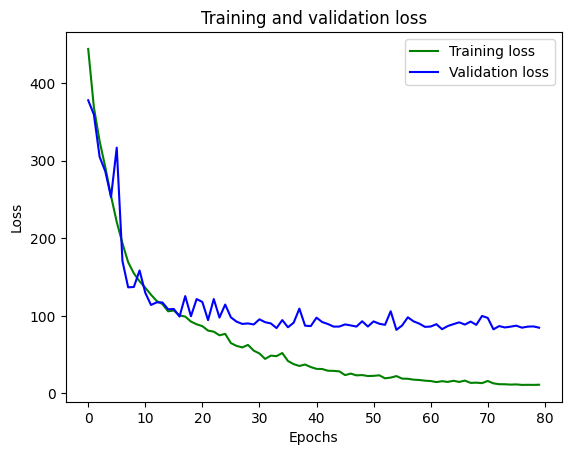

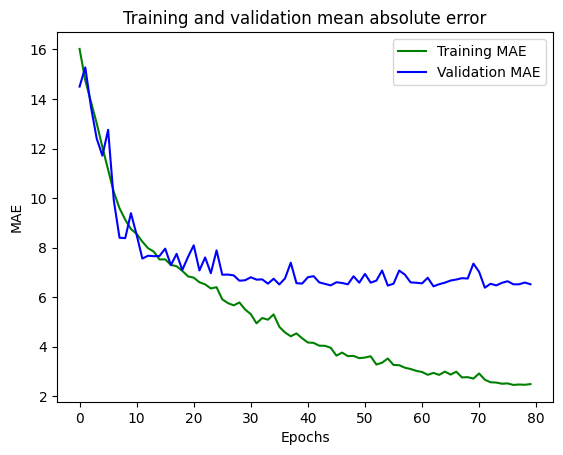

<Figure size 640x480 with 0 Axes>

In [18]:
plot_history(history, './Project/regression/normal/normal_regression_model')

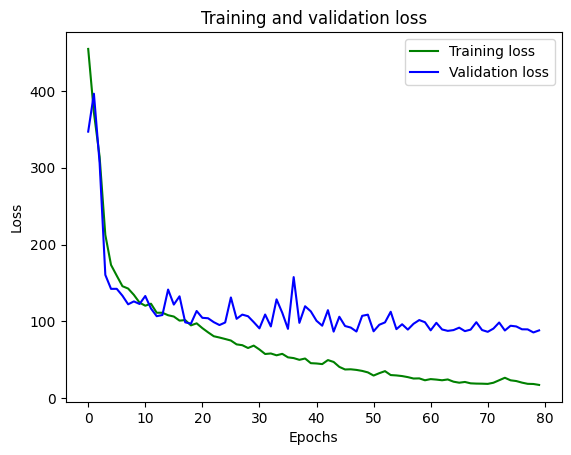

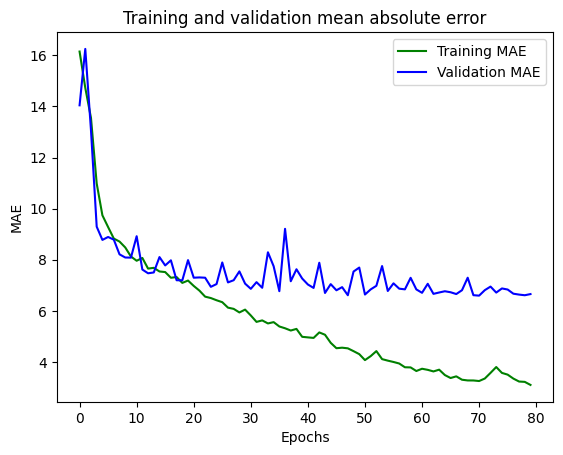

<Figure size 640x480 with 0 Axes>

In [19]:
plot_history(history_depth, './Project/regression/depthwise/depthwise_regression_model')

### Test Model

In [11]:
def test(model, test_loader, loss_fn ,name):
    test_loss = 0
    test_mae_sum = 0
    test_total = 0
    total_absolute_test_errors = torch.zeros(3)

    # create cuda events for timetracking
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().view(-1)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            test_total += labels.size(0)
            abs_error_test = torch.abs(outputs - labels)
            test_mae_sum += abs_error_test.sum().item()

            total_absolute_test_errors[0] += (abs_error_test <= 1).sum().item()
            total_absolute_test_errors[1] += (abs_error_test <= 5).sum().item()
            total_absolute_test_errors[2] += (abs_error_test <= 10).sum().item()

    end.record()
    torch.cuda.synchronize()
    test_loss /= test_total
    test_mae = test_mae_sum / test_total
    within_years = total_absolute_test_errors / test_total

    print(f'Model: {name},  Test Loss: {test_loss:.2f}, Test MAE: {test_mae:.2f}')
    print(f'Within 1 year: {within_years[0]:.2%}')
    print(f'Within 5 years: {within_years[1]:.2%}')
    print(f'Within 10 years: {within_years[2]:.2%}')
    print(f'Time:  {round(start.elapsed_time(end), 1) / 1000} seconds')

In [14]:
# load models
model_normal = CNNNet()
model_normal.load_state_dict(torch.load('./Project/regression/normal/regression_normal_model'))

depthwise_model = DepthwiseCNNNet()
depthwise_model.load_state_dict(torch.load('./Project/regression/depthwise/regression_depthwise_model'))

test(model_normal.to(device), test_loader, loss_fn, 'Normal CNN')
print()
test(depthwise_model.to(device), test_loader, loss_fn, 'Depthwise CNN')

Model: Normal CNN,  Test Loss: 90.82, Test MAE: 6.64
Within 1 year: 14.84%
Within 5 years: 53.42%
Within 10 years: 77.73%
Time:  8.316799999999999 seconds

Model: Depthwise CNN,  Test Loss: 100.37, Test MAE: 7.07
Within 1 year: 12.85%
Within 5 years: 51.31%
Within 10 years: 75.40%
Time:  4.3038 seconds
